<a href="https://colab.research.google.com/github/dhananjaylab/flower-detection/blob/main/flower_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil

# Standard Utility Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# TensorFlow/Keras Deep Learning Libraries
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# --- Configuration ---
# Set the desired image size (will be cropped/resized to this)
SIZE = 128
# Configuration for the Kaggle Dataset
KAGGLE_DATASET_ID = 'alxmamaev/flowers-recognition'
DESTINATION_DIR = './Image_CLF_Datasets/'
FLOWERS_DIR = os.path.join(DESTINATION_DIR, 'flowers/')
# --- End Configuration ---

In [10]:
# ...existing code...
# Colab-aware kaggle.json setup (replace previous kaggle checks with this cell)
import os, sys, json, shutil

def install_kaggle_json(src_path):
    dest_dir = os.path.expanduser("~/.kaggle")
    os.makedirs(dest_dir, exist_ok=True)
    dst = os.path.join(dest_dir, "kaggle.json")
    shutil.copy(src_path, dst)
    os.chmod(dst, 0o600)
    with open(dst, "r") as fh:
        data = json.load(fh)
    # set env vars for kaggle CLI fallback
    if "username" in data and "key" in data:
        os.environ["KAGGLE_USERNAME"] = data["username"]
        os.environ["KAGGLE_KEY"] = data["key"]
    elif "user" in data and "token" in data:
        os.environ["KAGGLE_USERNAME"] = data["user"]
        os.environ["KAGGLE_KEY"] = data["token"]
    print(f"Installed kaggle.json to {dst} and set KAGGLE_USERNAME/KAGGLE_KEY environment variables.")

# common locations to check (Colab, Codespace, workspace root)
candidates = [
    os.path.expanduser("~/.kaggle/kaggle.json"),
    "/root/.kaggle/kaggle.json",
    "/content/kaggle.json",
    "/content/drive/MyDrive/kaggle.json",
    "/workspaces/flower-detection/kaggle.json",
    "./kaggle.json"
]

found = False
for p in candidates:
    if p and os.path.exists(p):
        try:
            install_kaggle_json(p)
            found = True
            break
        except Exception as e:
            print("Failed to install from", p, ":", e)

# If running in Colab and not found, prompt upload
if not found and "google.colab" in sys.modules:
    from google.colab import files
    print("No kaggle.json found. Please upload kaggle.json (use the file dialog).")
    uploaded = files.upload()
    if "kaggle.json" in uploaded:
        with open("kaggle.json", "wb") as f:
            f.write(uploaded["kaggle.json"])
        install_kaggle_json("kaggle.json")
        found = True

if not found:
    # final fallback: check env vars
    if os.environ.get("KAGGLE_USERNAME") and os.environ.get("KAGGLE_KEY"):
        print("Kaggle credentials provided via environment variables.")
        found = True
    else:
        raise SystemExit(
            "Kaggle credentials not found. Place kaggle.json in ~/.kaggle/ or upload it in Colab, "
            "or set KAGGLE_USERNAME and KAGGLE_KEY environment variables."
        )

# Now safe to import kaggle
import kaggle
print("Kaggle API ready.")
# ...existing code...

Installed kaggle.json to /root/.kaggle/kaggle.json and set KAGGLE_USERNAME/KAGGLE_KEY environment variables.
Kaggle API ready.


In [12]:
# # ...existing code...
# # Ensure Kaggle credentials are present before importing kaggle
# kaggle_json = os.path("/content/kaggle.json")
# if os.path.exists(kaggle_json):
#     os.chmod(kaggle_json, 0o600)
#     import kaggle
#     print("Kaggle API configured via ~/.config/kaggle/kaggle.json")
# elif os.environ.get("KAGGLE_USERNAME") and os.environ.get("KAGGLE_KEY"):
#     import kaggle
#     print("Kaggle API configured via environment variables")
# else:
#     raise SystemExit(
#         "Kaggle credentials not found. Place kaggle.json in ~/.config/kaggle/ or set KAGGLE_USERNAME/KAGGLE_KEY."
#     )
# # ...existing code...

In [13]:
def download_and_extract_kaggle_dataset(dataset_id, dest_dir):
    """Downloads and extracts the Kaggle dataset."""

    os.makedirs(dest_dir, exist_ok=True)

    # Use the Kaggle CLI to download the dataset
    print(f"Downloading dataset: {dataset_id}...")
    try:
        # Downloads the zip file to the destination directory
        subprocess.run(['kaggle', 'datasets', 'download', '-d', dataset_id, '-p', dest_dir], check=True)
        print("Download complete.")
    except subprocess.CalledProcessError:
        print("\nERROR: Kaggle download failed. Please check credentials and connection.")
        print("Ensure the 'kaggle.json' file is correctly placed in ~/.kaggle/ for API authentication.")
        return False

    # Find and extract the downloaded zip file
    zip_files = [f for f in os.listdir(dest_dir) if f.endswith('.zip')]
    if not zip_files:
        print("Error: Downloaded zip file not found.")
        return False

    zip_path = os.path.join(dest_dir, zip_files[0])

    print(f"Extracting {zip_files[0]}...")
    shutil.unpack_archive(zip_path, dest_dir)
    os.remove(zip_path) # Clean up the zip file
    print(f"Data ready at: {FLOWERS_DIR}")

    # Renaming the extracted folder if necessary (specific to this dataset)
    extracted_folder_name = 'flowers'
    if extracted_folder_name not in os.listdir(dest_dir):
        # A common issue is the folder name being "flowers-recognition" or similar
        print("Attempting to locate flower images...")

    return True

In [14]:
# Check if data is already present before downloading
if not os.path.isdir(FLOWERS_DIR) or not os.listdir(FLOWERS_DIR):
    print("Dataset not found locally. Starting download and extraction...")
    success = download_and_extract_kaggle_dataset(KAGGLE_DATASET_ID, DESTINATION_DIR)
    if not success:
        raise SystemExit("Dataset setup failed. Cannot proceed with training.")
else:
    print(f"Dataset already found at {FLOWERS_DIR}. Skipping download.")

Dataset not found locally. Starting download and extraction...
Download complete.
Extracting flowers-recognition.zip...
Data ready at: ./Image_CLF_Datasets/flowers/


In [15]:
# --- Data Loading and Preprocessing ---
data = []
label = []

# Assuming the 'flowers' folder contains subfolders, where each subfolder name is a class label.
for folder in os.listdir(FLOWERS_DIR):
    folder_path = os.path.join(FLOWERS_DIR, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith("jpg"):
                label.append(folder)
                # Read, convert (BGR to RGB), and resize image
                img = cv2.imread(os.path.join(folder_path, file))
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    im = cv2.resize(img_rgb, (SIZE, SIZE))
                    data.append(im)

# Convert data into numerical values
X = np.array(data)
label_arr = np.array(label)

# Use label encoder and one-hot encode the data
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(label_arr)

# Get the list of class names in the order they were encoded
categories = encoder.classes_
NUM_CLASSES = len(categories)
print(f"\nDetected {NUM_CLASSES} classes: {categories}")

# One-hot encoding
y = to_categorical(y_encoded, NUM_CLASSES)

# Normalize the image data (scaling pixel values to [0, 1])
X = X / 255.0

# Split the dataset into 70% training and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Detected 5 classes: ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']
Train samples: 3021, Test samples: 1296


In [16]:
## 2. Build Convolutional Neural Network (CNN) Architecture 🏗️

model = Sequential(name='Flower_Classifier_CNN')

# First Convolutional Block
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(SIZE, SIZE, 3), name='Conv_1_64'))
model.add(MaxPooling2D(pool_size=(2,2), name='Pool_1'))

# Second Convolutional Block (Triple Conv Layers)
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu', name='Conv_2_128_a'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu', name='Conv_2_128_b'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu', name='Conv_2_128_c'))
model.add(MaxPooling2D(pool_size=(2,2), name='Pool_2'))

# Fully Connected Layers (Classifier)
model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(128, activation='relu', name='Dense_128'))
model.add(Dense(64, activation='relu', name='Dense_64'))
model.add(Dropout(rate=0.25, name='Dropout_0_25'))
# Output Layer
model.add(Dense(NUM_CLASSES, activation='softmax', name='Output_5_Classes'))

print("\n--- Model Summary ---")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Model Summary ---


Model: "Flower_Classifier_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1_64 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_1 (MaxPooling2D)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2_128_a (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2_128_b (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2_128_c (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_2 (MaxPooling2D)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_128 (Dense)               │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_0_25 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_5_Classes (Dense)        │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,156,741 (65.45 MB)

 Trainable params: 17,156,741 (65.45 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Generate model plot (requires pydot and graphviz)
try:
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("\nModel architecture saved to model_architecture.png")
except ImportError:
    print("\nWarning: pydot or graphviz not installed. Skipping model plot generation.")


Model architecture saved to model_architecture.png


In [20]:
## 3. Data Augmentation and Model Training ⚙️

# Image Data Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

batch_size = 32
epochs = 64

# Use Model.fit() which replaces the deprecated Model.fit_generator
print("\n--- Model Training Started ---")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=2
)
print("--- Model Training Finished ---")

# Save the trained model artifact
save_model(model, 'flower_classifier_model.h5')
print("\nTrained model saved as 'flower_classifier_model.h5'")


--- Model Training Started ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64
95/95 - 34s - 358ms/step - accuracy: 0.3300 - loss: 1.4621 - val_accuracy: 0.4414 - val_loss: 1.3260
Epoch 2/64
95/95 - 15s - 155ms/step - accuracy: 0.4287 - loss: 1.2935 - val_accuracy: 0.5147 - val_loss: 1.1803
Epoch 3/64
95/95 - 15s - 154ms/step - accuracy: 0.4532 - loss: 1.2472 - val_accuracy: 0.5162 - val_loss: 1.1502
Epoch 4/64
95/95 - 15s - 153ms/step - accuracy: 0.5157 - loss: 1.1873 - val_accuracy: 0.5502 - val_loss: 1.0896
Epoch 5/64
95/95 - 15s - 159ms/step - accuracy: 0.5293 - loss: 1.1380 - val_accuracy: 0.5594 - val_loss: 1.0942
Epoch 6/64
95/95 - 15s - 155ms/step - accuracy: 0.5637 - loss: 1.0862 - val_accuracy: 0.5756 - val_loss: 1.0472
Epoch 7/64
95/95 - 15s - 154ms/step - accuracy: 0.5763 - loss: 1.0583 - val_accuracy: 0.6096 - val_loss: 0.9637
Epoch 8/64
95/95 - 15s - 153ms/step - accuracy: 0.5780 - loss: 1.0443 - val_accuracy: 0.6042 - val_loss: 0.9852
Epoch 9/64
95/95 - 15s - 156ms/step - accuracy: 0.6034 - loss: 0.9988 - val_accuracy: 0.5910 - val_loss:

--- Model Training Finished ---

Trained model saved as 'flower_classifier_model.h5'


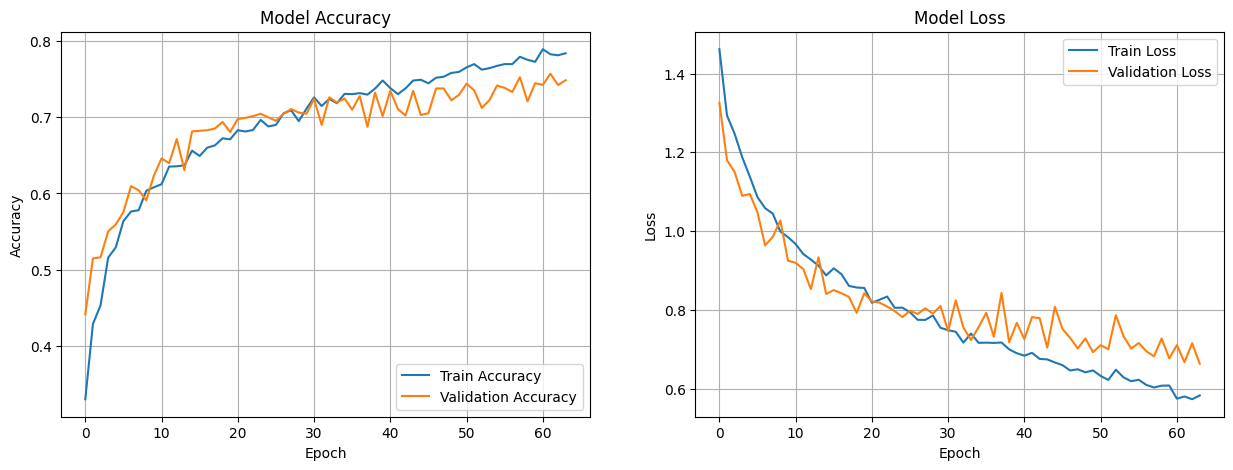

In [21]:
## 4. Evaluation and Visualization 📊

# --- A. Plot Training History ---
def plot_history(history):
    """Plots the training and validation loss and accuracy history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.show()

plot_history(history)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


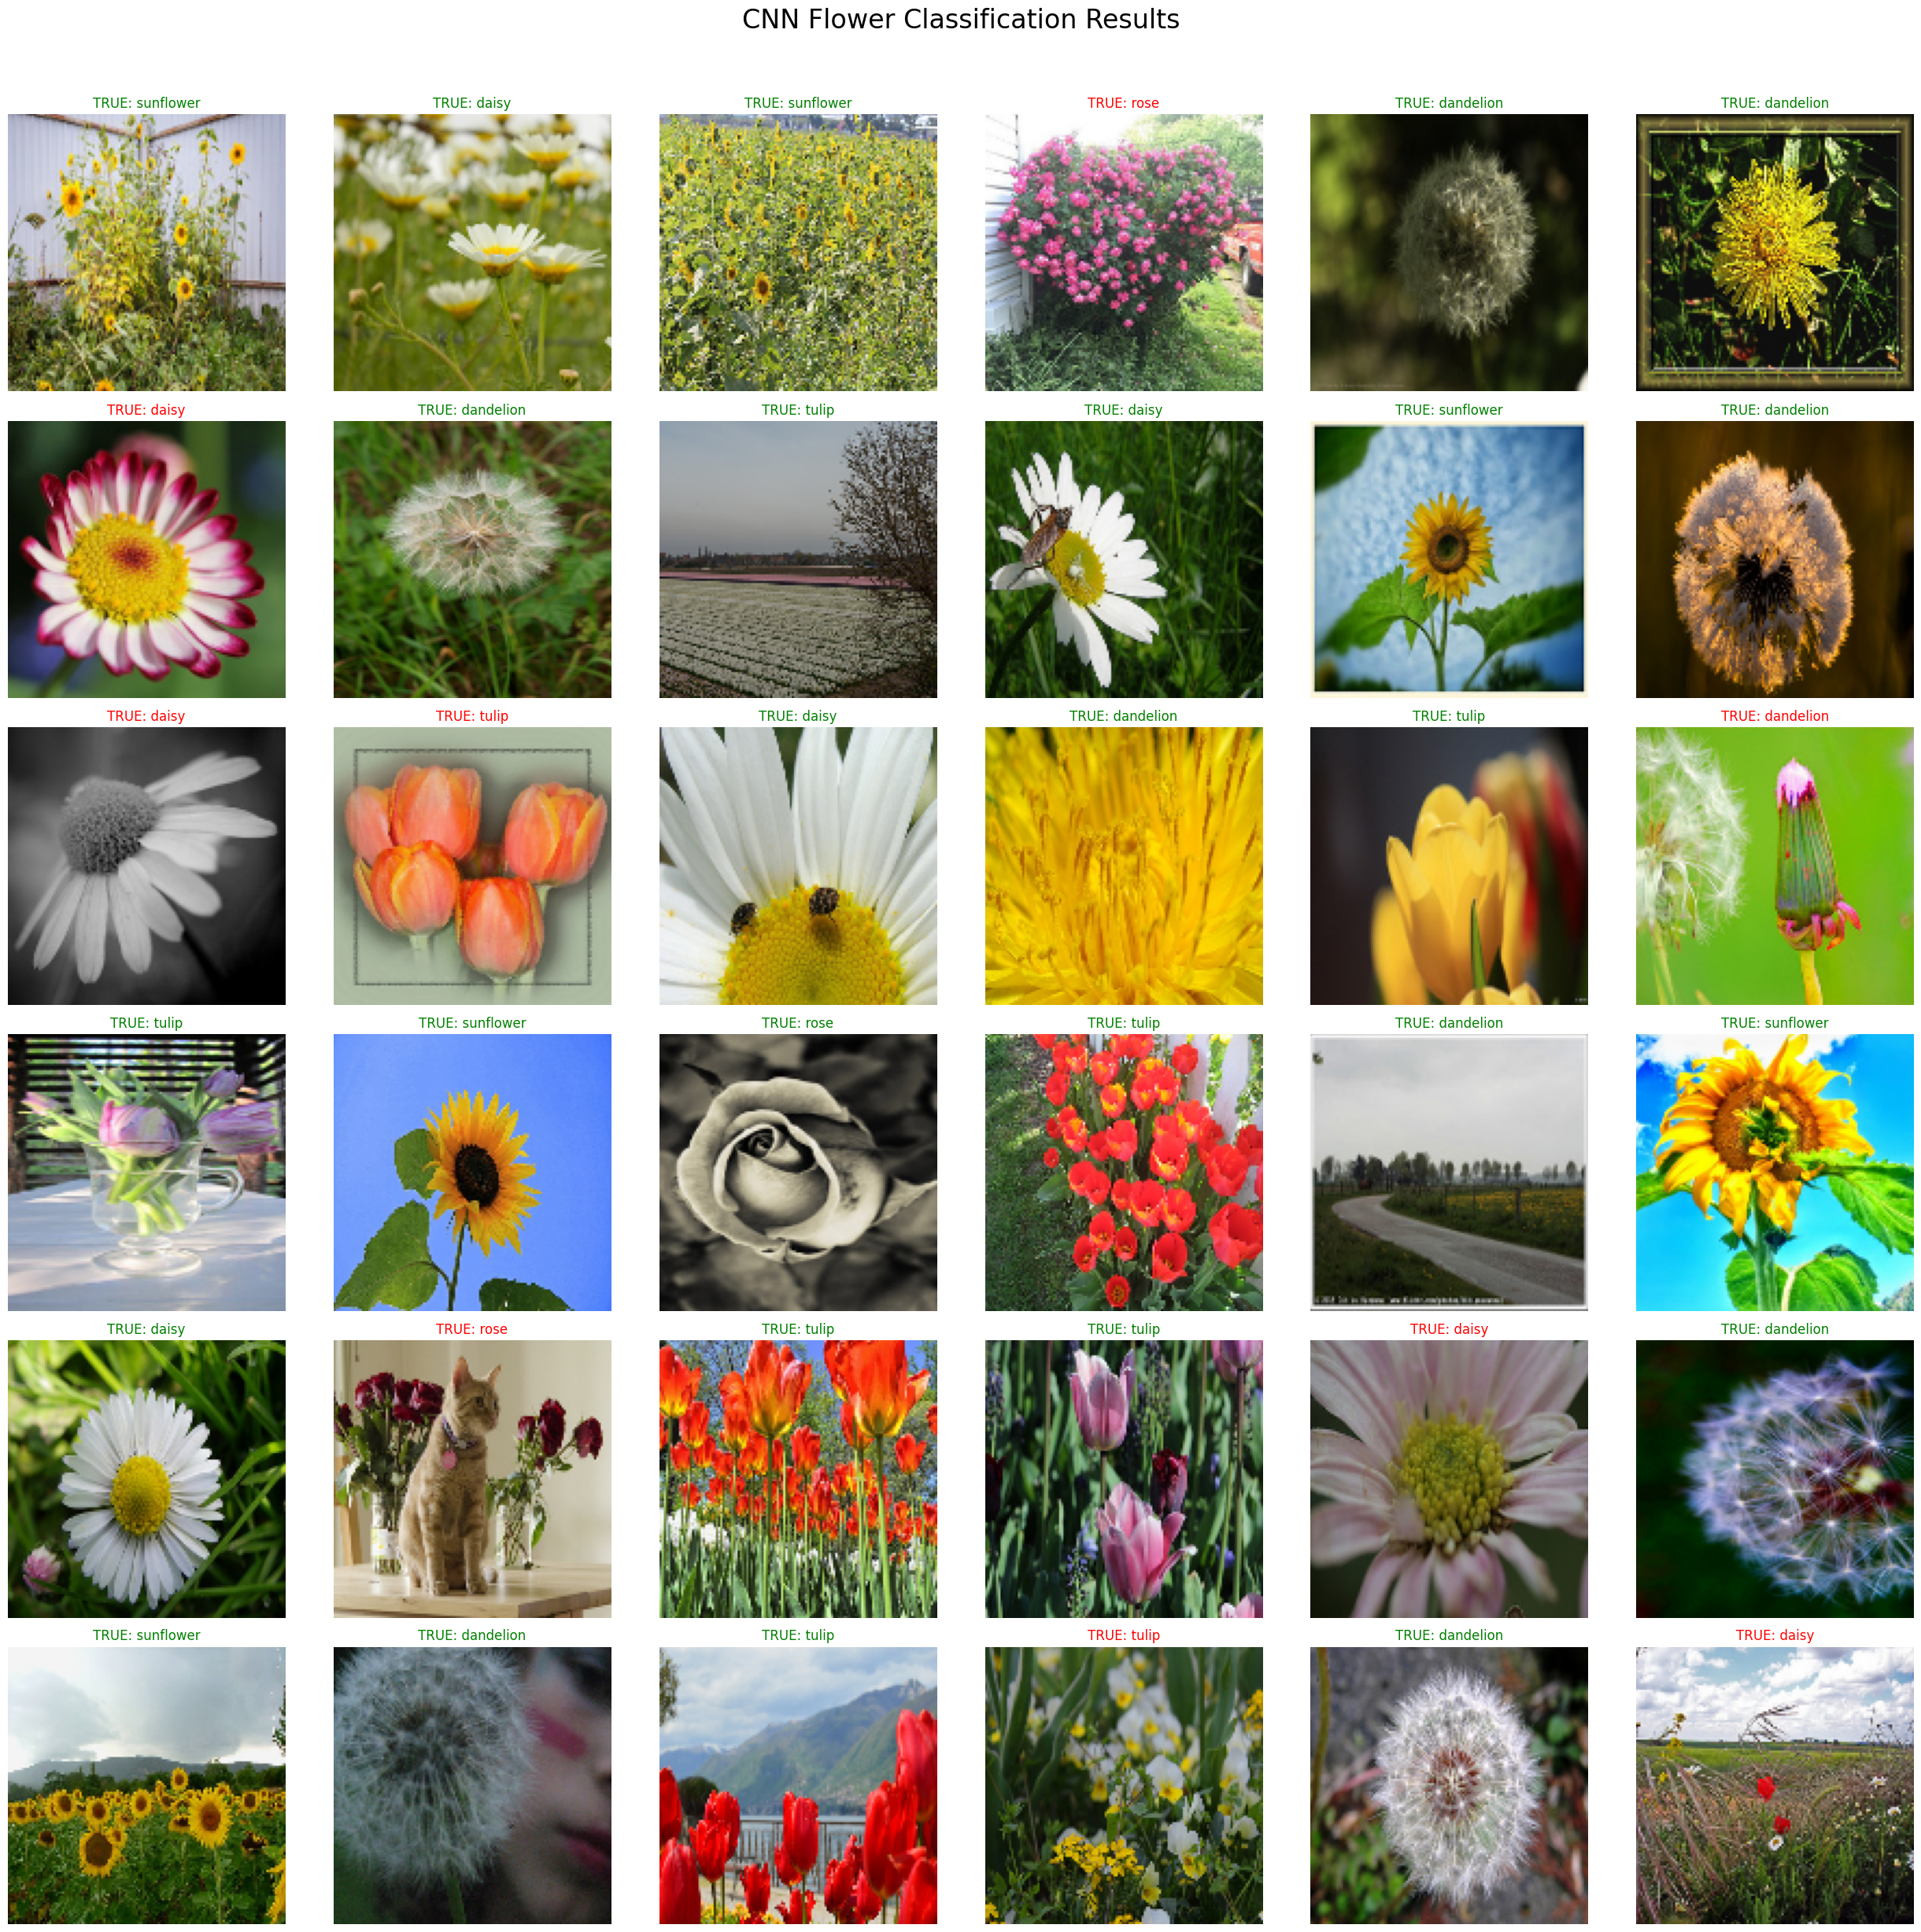

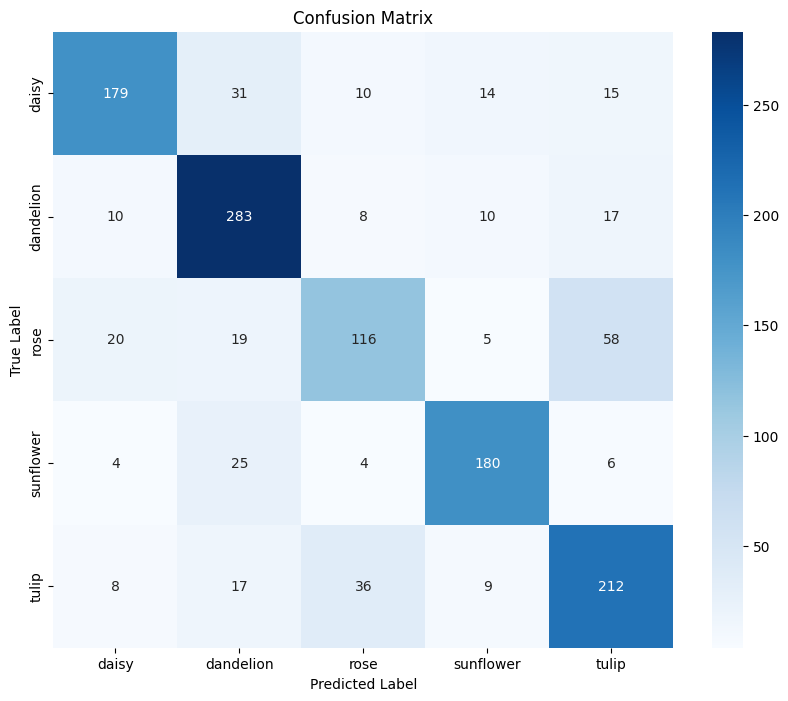

In [22]:
# --- B. Visualize Predictions on Test Set ---

# Run prediction once for efficiency
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Display 36 random test images with predictions
fig, ax = plt.subplots(6, 6, figsize=(25, 25))
fig.suptitle("CNN Flower Classification Results", fontsize=24)

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))

        true_label = categories[y_true_classes[k]]
        pred_label = categories[y_pred_classes[k]]

        is_correct = (true_label == pred_label)
        color = 'green' if is_correct else 'red'

        ax[i, j].set_title(f"TRUE: {true_label}", color=color)
        ax[i, j].set_xlabel(f"PREDICTED: {pred_label}", color=color)
        ax[i, j].imshow(X_test[k])
        ax[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- C. Plot Confusion Matrix ---

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()